# Analyis of GSMF SEAMAP Data - Work Papers
## Import Packages
The following packages were imported into the Anaconda Python interpreter. Plots are set to render in-line.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
%matplotlib inline

## Load Data
The GSMFC SEAMAP database is comprised of 12 tables describing the results of sampling efforts along the Gulf Coast. Four relevant tables have been imported into pandas dataframes:

1. SHHREC - Shrimp sampling records.
1. STAREC - Information on sampling locations during a survey.
1. ENVREC - Environmental data at specific sample locations.
1. INVREC

### Importing SHHREC Table
The SHHREC table provides information on individual shrimp sample surveys. It is imported below. It can be tied to the STAREC and ENVREC tables through the STATIONID column.

In [2]:
SHRREC = pd.read_csv('inputs_preprocessed/SHRREC.csv', index_col='SHRRECID')

### Importing STAREC Table

The STAREC table contains information on sampling locations.

Unfortunately, the CSV file contains escape character errors. Occasionally, line-breaks in the "COMSTAT" field, which appears to give comments on a given sample, are reflected in the resulting CSV export. Importing this table without first adjusting for these fields resulted in type errors and misassigned data. These characters were fixed in preprocessing.

Additionally, the following columns were added in Excel:

1. `CRUISE_LENGTH` - Measures the length of the sample in hours.
1. `YEAR` - Year of Sample
1. `MONTH` - Month of Sample
1. `DAY` - Day of Sample
1. `START_TIME` - Beginning Time of Sample

The following columns were removed, for they are non-key duplicates of the SHRREC table:

1. `CRUISEID`
1. `VESSEL`
1. `CRUISE_NO`
1. `P_STA_NO`

In [3]:
STAREC = pd.read_csv('inputs_preprocessed/STAREC.csv')
STAREC.drop(['CRUISEID', 'VESSEL', 'CRUISE_NO', 'P_STA_NO'], axis=1, inplace=True)

### Importing ENVREC Table

A table of environmental records per station was also imported. The following columns were removed, for they are non-key duplicates of the SHRREC table:

1. `CRUISEID`
1. `VESSEL`
1. `CRUISE_NO`
1. `P_STA_NO`

The following string columns were also removed because they are not used in our analysis and produced mixed type errors:

1. `CLD_TYPE`
1. `CTDFILE`

In [4]:
ENVREC = pd.read_csv('inputs_preprocessed/ENVREC.csv', low_memory=False)
ENVREC.drop(['CRUISEID', 'VESSEL', 'CRUISE_NO', 'P_STA_NO', 'CLD_TYPE', 'CTDFILE'], axis=1, inplace=True)

### Importing INVREC Table

In [6]:
INVREC = pd.read_csv('inputs_preprocessed/INVREC.csv')
INVREC.drop(['CRUISEID', 'VESSEL', 'CRUISE_NO', 'P_STA_NO'], axis=1, inplace=True)

C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (11,12,13,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Creating Augmented SHRREC Table
An augmented 2013, 2014 SHRREC table was created which adds any additional information in STAREC or ENVREC. It is saved as SHRREC2.

In [7]:
SHRREC2 = pd.merge(left=SHRREC, right=STAREC, on='STATIONID', how='left')
SHRREC2 = pd.merge(left=SHRREC2, right=ENVREC, on='STATIONID', how='left')
SHRREC2 = pd.merge(left=SHRREC2, right=INVREC, on='STATIONID', how='left')

SHRREC2 = SHRREC2.loc[SHRREC2['YEAR'] >= 2011]

## Aggregating Shrimp Data
Brown shrimp weight was aggregated by gender into the `weight_brown` column.

In [8]:
SHRREC2['weight_brown'] = SHRREC2[['SAMPLE_BF', 'SAMPLE_BM']].sum(axis=1)
SHRREC2['count_brown'] = SHRREC2[['CNT_BF', 'CNT_BM']].sum(axis=1)

## Latitude and Longitude
Surveys take place in designated "statistical zones," given by the `STAT_ZONE` field. In order to understand where these statistical zones are located, latitude and longitude columns were averaged for each statistical zone and exported as a csv. This was imported into Google Maps to graph where the various statistical zones are located.

In [7]:
STAT_ZONES = pd.pivot_table(SHRREC2.loc[SHRREC2['STAT_ZONE'] >= 16], values=['LATITUDE', 'LONGITUDE'], index='STAT_ZONE', aggfunc=np.mean)
STAT_ZONES.to_csv('STAT_ZONES.csv')

Statistical zone 18 is located just south of Galveston Bay. Statistical zones 19-21 are located along the coast to the West, and zones 17 and below are located to the East.

<img src="files/gulf.png" style="width: 900px;"/>

## Analysis of Results

An analysis dataframe was created based on SHRREC2.

In [10]:
analysis_df = SHRREC2.copy()
analysis_df.to_csv('test.csv')

### Cruise Length Analysis

Recently, most samples in the Western portion of the GoM have occurred in June. My analysis therefore focused on June in order to ensure similar seasonality.

A histogram of CRUISE_LENGTH is presented below.

Based on this analysis, it appears as though the majority of cruises are designed to last for thirty minutes. Often, there is some randomness in how long the cruise actually lasts, and other clusters exist, but the majority of cruises last for around thirty minutes.

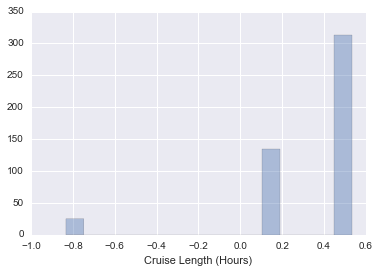

In [9]:
analysis_df = analysis_df.loc[analysis_df['MONTH'] == 6]
fig1_cl_hist = sns.distplot(analysis_df['CRUISE_LENGTH'], kde=False,
                            axlabel='Cruise Length (Hours)')

In order to ensure a comparison of like cruises, the sample is restricted to cruises which last between 24 and 36 minutes.

In [10]:
analysis_df = analysis_df.loc[analysis_df['CRUISE_LENGTH'] < .6]
analysis_df = analysis_df.loc[analysis_df['CRUISE_LENGTH'] > .4]

Some of the above data points had negative values. All appeared to last for `-50` minutes and took place during the 12th hour of the day. This appears to be bad data. However, even after making adjustments for (potentially) improperly coded "AM" and "PM" figures, these observations would not be included in the 30-minute cluster of results. Therefore, they are ignored in this analysis.

### Vessel Analysis

In creating GSMF SEAMAP over the past 30 years, the Gulf States Marine Fisheries Commission has utilized over 86 different vessels. These vessels may differ in ability to catch shrimp, so it is important to watch for any changes in the vessels utilized to perform samples.

The following table displays the number of times various vessels surveyed a given stat zone in a given year for stat zones 16 and up (within the 30 minute cluster only).

In [11]:
tab1_vessel = pd.pivot_table(analysis_df.loc[analysis_df['STAT_ZONE'] >= 16], values='weight_brown',
                             index=['STAT_ZONE', 'VESSEL'], columns='YEAR', aggfunc=len, dropna=True)
tab1_vessel.to_csv('tab/tab1_vessel.csv')
tab1_vessel

,YEAR,2013,2014
STAT_ZONE,VESSEL,,
16,4,19,17
17,4,NaN,24
18,4,21,20
19,4,17,18
20,4,15,17
21,4,10,13


Stat zones 16 and up were only surveyed by vessel 4, so these years should be comparable. Stat zone 17 was not surveyed in 2013, so it was excluded from my analysis. Stat zone 22 appears to have not been surveyed at all.

In [12]:
analysis_df = analysis_df.loc[analysis_df['STAT_ZONE'] >= 16]
analysis_df = analysis_df.loc[analysis_df['STAT_ZONE'] != 17]

### Brown Shrimp per Hour Variable
A new column, `weight_per_hour_brown` was added which measures pounds of brown shrimp caught per hour of sampling.

In [13]:
analysis_df['weight_per_hour_brown'] = analysis_df['weight_brown'] / analysis_df['CRUISE_LENGTH']

### 2014 Variable

A new dummy variable column labelled `YEAR_2014` is added to `analysis_df`. It takes the value '0' in 2013 and '1' in 2014. Its t- and p-values are used to test if a statistically significant change occured.

A new column labelled `'stat_group'` was also added. It is equal to `'group_a'` for stat zone 16 and `'group_b'` for all other stat zones.

In [14]:
analysis_df['YEAR_2014'] = 0
analysis_df.loc[analysis_df['YEAR'] == 2014, 'YEAR_2014'] = 1
analysis_df['YEAR_2014'] = analysis_df['YEAR_2014'].astype('category')

analysis_df['stat_group'] = 'group_b'
analysis_df.loc[analysis_df['STAT_ZONE'] == 16, 'stat_group'] = 'group_a'
analysis_df['stat_group'] = analysis_df['stat_group'].astype('category')

## Results
### Graphical Results
The average weight of brown shrimp caught per hour per cruise is displayed below.

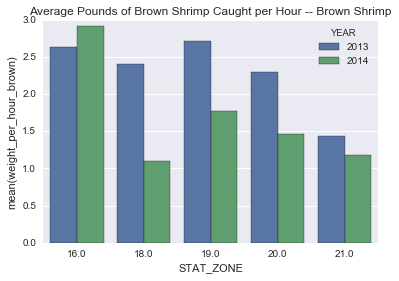

In [15]:
sns.barplot(x='STAT_ZONE', y='weight_per_hour_brown', hue='YEAR', data=analysis_df, ci=None)
sns.plt.title('Average Pounds of Brown Shrimp Caught per Hour -- Brown Shrimp')

### Zone Specific Statistical Tests
To test the statistical significance of the observed change, a regression was performed on each stat zone. The resulting significance is indicated as follows:

1. `*` - Siginificant at the 90% confidence level.
1. `**` - Significant at the 95% confidence level.
1. `***` - Significant at the 99% confidence level.

In [16]:
results_zone = pd.pivot_table(analysis_df, values='weight_per_hour_brown', columns='YEAR', index='STAT_ZONE', aggfunc=np.mean)
results_zone.columns = ['Y2013', 'Y2014']
results_zone['percent_change'] = results_zone['Y2014'] / results_zone['Y2013'] - 1

for n in results_zone.index:
    temp_model = sm.ols(formula='weight_per_hour_brown ~ YEAR_2014', data=analysis_df.loc[analysis_df['STAT_ZONE']==n]).fit()
    results_zone.loc[n, 'tvalue'] = temp_model.tvalues[1]
    results_zone.loc[n, 'pvalue'] = temp_model.pvalues[1]

results_zone['sig'] = ' '
results_zone.loc[results_zone['pvalue']<0.1, 'sig'] = '*'
results_zone.loc[results_zone['pvalue']<0.05, 'sig'] = '**'
results_zone.loc[results_zone['pvalue']<0.01, 'sig'] = '***'

results_zone.to_csv('tab/tab2_res_zone')
results_zone

,Y2013,Y2014,percent_change,tvalue,pvalue,sig
STAT_ZONE,,,,,,
16,2.630114,2.910906,0.106761,0.354233,0.725352,
18,2.400849,1.102253,-0.540890,-2.439416,0.019362,**
19,2.713055,1.774926,-0.345783,-1.529260,0.135730,
20,2.299285,1.464602,-0.363019,-1.514079,0.140471,
21,1.436313,1.183839,-0.175779,-0.363889,0.719579,


An increase is observed in stat zone 16 for 2013 to 2014. Decreases are observed in all other zones. The decrease observed in zone 18 is statistically significant.
### Regional Statistical Significance Test
I was asked to repeat this analysis grouping together stat zones 18 through 21.

In this model, the YEAR_2014 parameter has a t-value of `-3.123` and a p-value of `0.002`. This means it is statistically significant at the 99% confidence level.

In [18]:
results_group = pd.pivot_table(analysis_df, values='weight_per_hour_brown', columns='YEAR', index='stat_group', aggfunc=np.mean)
results_group.columns = ['Y2013', 'Y2014']
results_group['percent_change'] = results_group['Y2014'] / results_group['Y2013'] - 1

for n in results_group.index:
    temp_model = sm.ols(formula='weight_per_hour_brown ~ YEAR_2014', data=analysis_df.loc[analysis_df['stat_group']==n]).fit()
    results_group.loc[n, 'tvalue'] = temp_model.tvalues[1]
    results_group.loc[n, 'pvalue'] = temp_model.pvalues[1]

results_group['sig'] = ' '
results_group.loc[results_group['pvalue']<0.1, 'sig'] = '*'
results_group.loc[results_group['pvalue']<0.05, 'sig'] = '**'
results_group.loc[results_group['pvalue']<0.01, 'sig'] = '***'

results_group.index = ['Zone 16', 'Zones 18 through 21']

results_group.to_csv('tab/tab3_res_group')
results_group

,Y2013,Y2014,percent_change,tvalue,pvalue,sig
Zone 16,2.630114,2.910906,0.106761,0.354233,0.725352,
Zones 18 through 21,2.307813,1.386498,-0.399215,-3.123103,0.002210,***


### Excel Output
As a convenience, the underlying data behind these graphs and figures are saved as a csv and attached.

In [35]:
analysis_df.to_csv("tab/tab4_analysis_df.csv")